In [1]:
import calendar
import itertools
import json
import math
import os
import pickle
import random
import sys
import time
from datetime import datetime

import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
from xgboost import XGBRegressor

In [2]:
def fit_and_evaluate_model(training_data,
                           evaluation_data,
                           xgboost_parameters,
                           feature_vector_length=1):
    x_train = []
    y_train = []
    for i in range(feature_vector_length, len(training_data)):
        feature_vector = training_data[i - feature_vector_length:i]
        x_train.append(feature_vector)
        y_train.append([training_data[i]])

    x_train = np.array(x_train, np.float32)
    y_train = np.array(y_train, np.float32)

    model = XGBRegressor(**xgboost_parameters)
    model.fit(x_train, y_train)

    concatenated_evaluation_data = training_data[-feature_vector_length:] + evaluation_data

    x_test = []
    y_test = []
    for i in range(feature_vector_length, len(concatenated_evaluation_data)):
        feature_vector = concatenated_evaluation_data[i - feature_vector_length:i]
        x_test.append(feature_vector)
        y_test.append([concatenated_evaluation_data[i]])

    x_test = np.array(x_test, np.float32)
    y_test = np.array(y_test, np.float32)
    y_hat = model.predict(x_test)

    y_test_flat = y_test.ravel()
    y_hat_flat = y_hat.ravel()
    error = np.mean(np.abs(y_hat_flat - y_test_flat) / y_test_flat) * 100.0

    return model, error

In [3]:
def find_optimal_xgboost_model_without_trend(data, evaluation_split=0.2):
    max_feature_vector_length = min(20, len(data) // 2)
    best_feature_vector_length = -1
    min_error = sys.float_info.max
    best_xgboost_parameters = None

    xgboost_parameters_grid = {
        'learning_rate': [0.01],
        'max_depth': [7],
        'min_child_weight': [1],
        'gamma': [0.4],
        'colsample_bytree': [1.0],
        'n_estimators': [2000]
    }

    total_parameter_combinations = max_feature_vector_length

    total_parameter_grid_combinations = 1
    parameter_index_key = {}
    parameters_grid_indices = []
    i = 0
    for key in xgboost_parameters_grid:
        n = len(xgboost_parameters_grid[key])
        parameters_grid_indices.append(range(n))
        parameter_index_key[i] = key
        total_parameter_grid_combinations *= n
        i += 1
    total_parameter_combinations *= total_parameter_grid_combinations

    evaluation_data_size = int(round(len(data) * evaluation_split))
    training_data_size = len(data) - evaluation_data_size

    training_data = data[:training_data_size]
    evaluation_data = data[training_data_size:]

    for feature_vector_length in range(1, max_feature_vector_length + 1):
        if feature_vector_length >= len(evaluation_data):
            continue

        parameter_combinations = itertools.product(*parameters_grid_indices)

        for parameter_combination in parameter_combinations:
            xgboost_parameters = {}
            for i in range(len(parameter_combination)):
                param_key = parameter_index_key[i]
                xgboost_parameters[param_key] = xgboost_parameters_grid[param_key][parameter_combination[i]]

            model, error = fit_and_evaluate_model(training_data,
                                                  evaluation_data,
                                                  xgboost_parameters,
                                                  feature_vector_length)

            if error < min_error:
                min_error = error
                best_feature_vector_length = feature_vector_length
                best_xgboost_parameters = xgboost_parameters

    x_train = []
    y_train = []
    for i in range(best_feature_vector_length, len(data)):
        feature_vector = data[i - best_feature_vector_length:i]
        x_train.append(feature_vector)
        y_train.append([data[i]])

    x_train = np.array(x_train, np.float32)
    y_train = np.array(y_train, np.float32)

    model = XGBRegressor(**best_xgboost_parameters)
    model.fit(x_train, y_train)

    parameters = {
        'feature_vector_length': best_feature_vector_length,
    }
    parameters.update(best_xgboost_parameters)

    return model, parameters, min_error


def recursive_multi_step_forecast_without_trend(data, steps, model, parameters):
    feature_vector_length = parameters['feature_vector_length']

    forecast_data = data[-feature_vector_length:]
    multi_step = []

    for i in range(steps):
        next_prediction = float(model.predict(np.array([forecast_data]))[0])
        multi_step.append(next_prediction)
        forecast_data = forecast_data[1:] + [next_prediction]

    return multi_step

In [4]:
def generate_dummy_data():
    def generating_function(x):
        total = np.zeros(x.shape, np.float32)
        for i in range(1, 5):
            total += i * np.sin(x * math.pi / i)
        return total + 10

    train_x = np.arange(0, 100)
    train_y = generating_function(train_x)
    train_y += np.random.normal(0, 5)
    train_y[train_y < 0] = 0

    return train_x, train_y


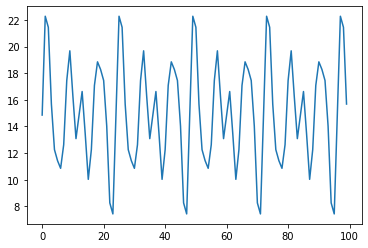

In [5]:
train_x, train_y = generate_dummy_data()

plt.plot(train_x, train_y)
plt.show()

In [6]:
list_train_y = list(train_y)
model, parameters, error = find_optimal_xgboost_model_without_trend(list_train_y)
print(error)
print(parameters)

1.0628622956573963
{'feature_vector_length': 19, 'learning_rate': 0.01, 'max_depth': 7, 'min_child_weight': 1, 'gamma': 0.4, 'colsample_bytree': 1.0, 'n_estimators': 2000}


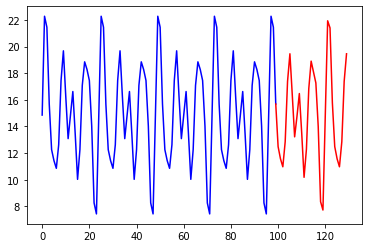

In [7]:
next_predictions = recursive_multi_step_forecast_without_trend(list_train_y, 30, model, parameters)
plt.plot(train_x, train_y, color='blue')
plt.plot(list(range(len(train_y) - 1, len(train_y) + 30)), list_train_y[-1:] + next_predictions, color='red')
plt.show()


## Predictions and Original Values

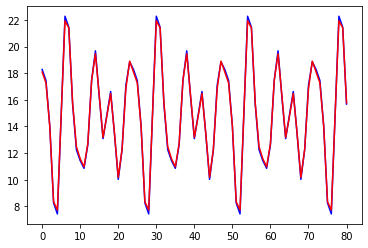

In [8]:
shifted_arrays = []
feature_vector_length = parameters['feature_vector_length']
for i in range(feature_vector_length):
    shifted_arrays.append(list_train_y[i: i - feature_vector_length])
shifted_arrays = np.expand_dims(shifted_arrays, -1)
y_true = np.array(list_train_y[feature_vector_length:])
input_x = np.concatenate(shifted_arrays, -1)
y_pred = model.predict(input_x)

plt.plot(range(len(y_true)), y_true.ravel(), color='blue')
plt.plot(range(len(y_pred)), y_pred.ravel(), color='red')
plt.show()

## Modeling Residuals (errors in Predictions)

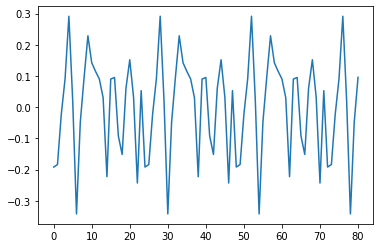

In [115]:
residuals = y_pred.ravel() - y_true.ravel()
plt.plot(range(len(residuals)), residuals)

# Method 1 - Statistical 

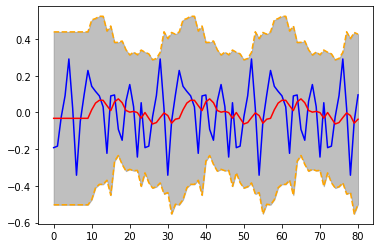

In [128]:
import pandas as pd

window = 9
half_window = window // 2

moving_average = pd.Series(residuals).rolling(window).mean().to_numpy()[window - 1:]
moving_average = list(moving_average)
moving_average = [moving_average[0] for _ in range(window)] + moving_average #+ [moving_average[-1] for _ in range(half_window)]
moving_average = np.array(moving_average)[:-1]
moving_std = pd.Series(residuals).rolling(window).std().to_numpy()[window - 1:]
moving_std = list(moving_std)
moving_std = [moving_std[0] for _ in range(window)] + moving_std #+ [moving_std[-1] for _ in range(half_window)]
moving_std = np.array(moving_std)[:-1]

plt.plot(range(len(residuals)), residuals, color='blue')
plt.plot(range(len(moving_average)), moving_average, color='red')
lower_bound = moving_average - 2.5 * moving_std
upper_bound = moving_average + 2.5 * moving_std
plt.plot(range(len(moving_std)), lower_bound, linestyle='dashed', color='orange')
plt.plot(range(len(moving_std)), upper_bound, linestyle='dashed', color='orange')

plt.fill_between(range(len(moving_std)), lower_bound, upper_bound, color='gray', alpha=0.5)
plt.show()

In [129]:
print(np.any(lower_bound >= residuals))
print(np.any(upper_bound <= residuals))

False
False


In [130]:
next_prediction = model.predict([y_pred[-feature_vector_length:]])[0]
print(next_prediction)

12.487696


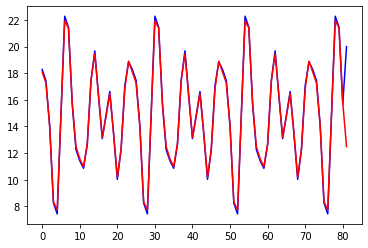

In [138]:
y_true_with_anomaly = list(y_true)
y_true_with_anomaly.append(20.0)
y_true_with_anomaly = np.array(y_true_with_anomaly)

y_pred_with_anomaly = list(y_pred)
y_pred_with_anomaly.append(next_prediction)
y_pred_with_anomaly = np.array(y_pred_with_anomaly)

plt.plot(range(len(y_true_with_anomaly)), y_true_with_anomaly.ravel(), color='blue')
plt.plot(range(len(y_pred_with_anomaly)), y_pred_with_anomaly.ravel(), color='red')
plt.show()

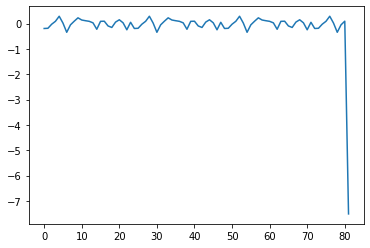

In [139]:
residuals_with_anomaly = y_pred_with_anomaly.ravel() - y_true_with_anomaly.ravel()
plt.plot(range(len(residuals_with_anomaly)), residuals_with_anomaly)

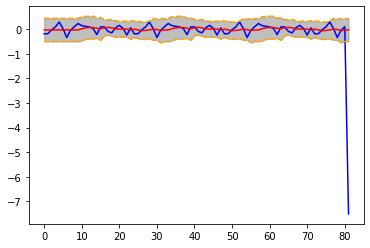

In [143]:
window = 9
half_window = window // 2

moving_average_with_anomaly = pd.Series(residuals_with_anomaly).rolling(window).mean().to_numpy()[window - 1:]
moving_average_with_anomaly = list(moving_average_with_anomaly)
moving_average_with_anomaly = [moving_average_with_anomaly[0] for _ in range(window)] + moving_average_with_anomaly 
moving_average_with_anomaly = np.array(moving_average_with_anomaly)[:-1]
moving_std_with_anomaly = pd.Series(residuals_with_anomaly).rolling(window).std().to_numpy()[window - 1:]
moving_std_with_anomaly = list(moving_std_with_anomaly)
moving_std_with_anomaly = [moving_std_with_anomaly[0] for _ in range(window)] + moving_std_with_anomaly 
moving_std_with_anomaly = np.array(moving_std_with_anomaly)[:-1]

plt.plot(range(len(residuals_with_anomaly)), residuals_with_anomaly, color='blue')
plt.plot(range(len(moving_average_with_anomaly)), moving_average_with_anomaly, color='red')
lower_bound = moving_average_with_anomaly - 2.5 * moving_std_with_anomaly
upper_bound = moving_average_with_anomaly + 2.5 * moving_std_with_anomaly
plt.plot(range(len(moving_std_with_anomaly)), lower_bound, linestyle='dashed', color='orange')
plt.plot(range(len(moving_std_with_anomaly)), upper_bound, linestyle='dashed', color='orange')

plt.fill_between(range(len(moving_std_with_anomaly)), lower_bound, upper_bound, color='gray', alpha=0.5)
plt.show()

In [144]:
print(np.any(lower_bound >= residuals_with_anomaly))
print(np.any(upper_bound <= residuals_with_anomaly))

True
False


## Method 2 - Density Based

In [188]:
shifted_arrays = []
feature_length = 9
for i in range(feature_length):
    shifted_arrays.append(residuals[i: len(residuals) + i - feature_length + 1])
shifted_arrays = np.expand_dims(shifted_arrays, -1)
input_x = np.concatenate(shifted_arrays, -1)

from sklearn.cluster import DBSCAN
dbscan=DBSCAN(eps=0.57)
density_model = dbscan.fit(input_x)

print(density_model.labels_)


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [189]:
shifted_arrays = []
feature_length = 9
for i in range(feature_length):
    shifted_arrays.append(residuals_with_anomaly[i: len(residuals_with_anomaly) + i - feature_length + 1])
shifted_arrays = np.expand_dims(shifted_arrays, -1)
input_x = np.concatenate(shifted_arrays, -1)

dbscan=DBSCAN(eps=0.57)
density_model = dbscan.fit(input_x)

print(density_model.labels_)

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0 -1]


## Method 3 - Proximity Based

In [194]:
shifted_arrays = []
feature_length = 9
for i in range(feature_length):
    shifted_arrays.append(residuals[i: len(residuals) + i - feature_length + 1])
shifted_arrays = np.expand_dims(shifted_arrays, -1)
input_x = np.concatenate(shifted_arrays, -1)

from sklearn.neighbors import NearestNeighbors
nbrs = NearestNeighbors(n_neighbors=3).fit(input_x)
distances, indices = nbrs.kneighbors(input_x)
distances

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0

In [195]:
shifted_arrays = []
feature_length = 9
for i in range(feature_length):
    shifted_arrays.append(residuals_with_anomaly[i: len(residuals_with_anomaly) + i - feature_length + 1])
shifted_arrays = np.expand_dims(shifted_arrays, -1)
input_x = np.concatenate(shifted_arrays, -1)

nbrs = NearestNeighbors(n_neighbors=3).fit(input_x)
distances, indices = nbrs.kneighbors(input_x)
distances

array([[0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.